# Wstęp

## Wymagane biblioteki

In [ ]:
!pip install smac
!pip install scikit-optimize
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
!pip install xgboost==0.90
!pip install openml

# Get additional files from Github
!wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 5.7 MB/s eta 0:00:00
  Created wheel for smac: filename=smac-2.0.2-py3-none-any.whl size=207413 sha256=e064f0c8676ee537cf0af9e43f1695372fca9d9d4c02b319700de7f29f9bf6ff
  Stored in directory: /root/.cache/pip/wheels/9e/7b/0f/70fa663d850965f42f74fd6ed340a48de9e0f88526e4c57fa4
  Created wheel for pynisher: fil

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import openml

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#bayes:
from ConfigSpace import Configuration, ConfigurationSpace
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence
from scipy.stats import uniform, randint

import smac

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
results_rs = pd.DataFrame()
results_bs4 = pd.DataFrame()
results_bs1 = pd.DataFrame()
results_bs2 = pd.DataFrame()
results_bs3 = pd.DataFrame()

In [ ]:
np.random.seed(123)

## Przygotowanie siatek parametrów

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rfc_params= [{
 'bootstrap': [True, False],   # replace
 'max_features': uniform(0.01, 1),   # mtry
 'min_samples_split': uniform(0.01, 1),  # min.node.size
 'n_estimators': randint(1, 2001),   # num.trees
 #'max_samples': uniform(0.01, 1)      # sample.fraction - powoduje błędy
}]

In [ ]:
rfc_params_bayes= [{
 'bootstrap': [True, False],   # replace
 'max_features': Real(0.01, 1),   # mtry
 'min_samples_split': Real(0.01, 1),  # min.node.size
 'n_estimators': Integer(1, 2000),   # num.trees
}]

In [ ]:
rfc = RandomForestClassifier(random_state=21)

# Eksperymenty

## adult ID: 45068

### Przygotowanie danych

In [ ]:
dataset1 = openml.datasets.get_dataset(45068)
X_adult, _, _, _ = dataset1.get_data(dataset_format="dataframe")
X_adult.head()

In [ ]:
X_adult.info()

In [ ]:
X_adult.describe()

In [ ]:
y_adult = X_adult['class']
X_adult = X_adult.drop('class', axis=1)

le = LabelEncoder()
dummy_y = le.fit_transform(y_adult)
dummy_X = pd.get_dummies(X_adult).drop(["sex_Male"], axis=1)

Xa_train, Xa_test, ya_train, ya_test = train_test_split(dummy_X, dummy_y,test_size=0.2)

### RandomSearch

In [ ]:
rfc_grid1 = RandomizedSearchCV(rfc, rfc_params, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid1.fit(Xa_train, ya_train)
rfc_est1 = rfc_grid1.best_estimator_
rfc_res1 = rfc_grid1.cv_results_
rfc_params1=rfc_grid1.best_params_
print(rfc_params1)

In [ ]:
rfc_auc1 = roc_auc_score(ya_test, rfc_est1.predict_proba(Xa_test)[:, 1])
print(rfc_auc1)

In [ ]:
results_rs["a_params"] = rfc_grid1.cv_results_["params"]
results_rs["a_score"] = rfc_grid1.cv_results_["mean_test_score"]

### Bayes

In [ ]:
rfc_grid1_bayes = BayesSearchCV(rfc, rfc_params_bayes, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid1_bayes.fit(Xa_train, ya_train)
rfc_est1_bayes = rfc_grid1_bayes.best_estimator_
rfc_res1_bayes = rfc_grid1_bayes.cv_results_
rfc_params1_bayes=rfc_grid1_bayes.best_params_
print(rfc_params1_bayes)

rfc_auc1_bayes = roc_auc_score(ya_test, rfc_est1_bayes.predict_proba(Xa_test)[:, 1])
print(rfc_auc1_bayes)

In [ ]:
results_bs1["params"] = rfc_grid1_bayes.cv_results_["params"]
results_bs1["score"] = rfc_grid1_bayes.cv_results_["mean_test_score"]

## blood-transfusion-service-center ID: 1464

### Przygotowanie danych

In [ ]:
dataset2 = openml.datasets.get_dataset(1464)
X_blood, _, _, _ = dataset2.get_data(dataset_format="dataframe")
X_blood.head()

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


,V1,V2,V3,V4,Class
0,2,50,12500.0,98,2
1,0,13,3250.0,28,2
2,1,16,4000.0,35,2
3,2,20,5000.0,45,2
4,1,24,6000.0,77,1


In [ ]:
X_blood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      748 non-null    uint8   
 1   V2      748 non-null    uint8   
 2   V3      748 non-null    float64 
 3   V4      748 non-null    uint8   
 4   Class   748 non-null    category
dtypes: category(1), float64(1), uint8(3)
memory usage: 9.0 KB


In [ ]:
X_blood.describe()

,V1,V2,V3,V4
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


In [ ]:
y_blood = X_blood['Class']
X_blood = X_blood.drop('Class', axis=1)

In [ ]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_blood, y_blood,test_size=0.2)

### RandomSearch

In [ ]:
rfc_grid = RandomizedSearchCV(rfc1,rfc_params, random_state=21)
rfc_grid.fit(Xb_train, yb_train)

In [ ]:
rfc_grid.best_params_

In [ ]:
rfc_grid2 = RandomizedSearchCV(rfc, rfc_params, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid2.fit(Xb_train, yb_train)
rfc_est2 = rfc_grid2.best_estimator_
rfc_res2 = rfc_grid2.cv_results_
rfc_params2=rfc_grid2.best_params_
print(rfc_params2)

{'bootstrap': True, 'max_features': 0.9336580482441975, 'min_samples_split': 0.07996941969626091, 'n_estimators': 706}


{'bootstrap': True, 'max_features': 0.771509849862193, 'min_samples_split': 0.375284809588861, 'n_estimators': 661}

In [ ]:
rfc_auc2 = roc_auc_score(yb_test, rfc_est2.predict_proba(Xb_test)[:, 1])
print(rfc_auc2)

0.6607954545454545


In [ ]:
rfc_est2

RandomForestClassifier(max_features=0.9336580482441975,
                       min_samples_split=0.07996941969626091, n_estimators=706,
                       random_state=21)

RandomForestClassifier(max_features=0.771509849862193,
                       min_samples_split=0.375284809588861, n_estimators=661,
                       random_state=21)

In [ ]:
results_rs["b_params"] = rfc_grid2.cv_results_["params"]
results_rs["b_score"] = rfc_grid2.cv_results_["mean_test_score"]

### Bayes

In [ ]:
rfc_grid_bayes = BayesSearchCV(rfc1, rfc_params_bayes, random_state=21)
rfc_grid_bayes.fit(Xb_train, yb_train)

In [ ]:
rfc_grid_bayes.best_params_

In [ ]:
rfc_grid2_bayes = BayesSearchCV(rfc, rfc_params_bayes, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid2_bayes.fit(Xb_train, yb_train)
rfc_est2_bayes = rfc_grid2_bayes.best_estimator_
rfc_res2_bayes = rfc_grid2_bayes.cv_results_
rfc_params2_bayes=rfc_grid2_bayes.best_params_
print(rfc_params2_bayes)

rfc_auc2_bayes = roc_auc_score(yb_test, rfc_est2_bayes.predict_proba(Xb_test)[:, 1])
print(rfc_auc2_bayes)

OrderedDict([('bootstrap', True), ('max_features', 0.823453460163615), ('min_samples_split', 0.45757493869565197), ('n_estimators', 2000)])
0.6748863636363637


In [ ]:
results_bs2["params"] = rfc_grid2_bayes.cv_results_["params"]
results_bs2["score"] = rfc_grid2_bayes.cv_results_["mean_test_score"]

## phoneme ID: 1489

### Przygotowanie danych

In [ ]:
dataset3 = openml.datasets.get_dataset(1489)
X_bank, _, _, _ = dataset3.get_data(dataset_format="dataframe")
X_bank.head()

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


,V1,V2,V3,V4,Class
0,3.62160,8.6661,-2.8073,-0.44699,1
1,4.54590,8.1674,-2.4586,-1.46210,1
2,3.86600,-2.6383,1.9242,0.10645,1
3,3.45660,9.5228,-4.0112,-3.59440,1
4,0.32924,-4.4552,4.5718,-0.98880,1


In [ ]:
X_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      1372 non-null   float64 
 1   V2      1372 non-null   float64 
 2   V3      1372 non-null   float64 
 3   V4      1372 non-null   float64 
 4   Class   1372 non-null   category
dtypes: category(1), float64(4)
memory usage: 44.5 KB


In [ ]:
X_bank.describe()

,V1,V2,V3,V4
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [ ]:
y_bank = X_bank['Class']
X_bank = X_bank.drop('Class', axis=1)

Xba_train, Xba_test, yba_train, yba_test = train_test_split(X_bank, y_bank,test_size=0.2)

### RandomSearch

In [ ]:
rfc_grid3 = RandomizedSearchCV(rfc, rfc_params, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid3.fit(Xba_train, yba_train)

{'bootstrap': True, 'max_features': 0.7425674873082762, 'min_samples_split': 0.012100500892840307, 'n_estimators': 1894}


AttributeError: ignored

In [ ]:
rfc_est3 = rfc_grid3.best_estimator_
rfc_res3 = rfc_grid3.cv_results_
rf_params3=rfc_grid3.best_params_
print(rf_params3)

rfc_auc3 = roc_auc_score(yba_test, rfc_est3.predict_proba(Xba_test)[:, 1])
print(rfc_auc3)

{'bootstrap': True, 'max_features': 0.7425674873082762, 'min_samples_split': 0.012100500892840307, 'n_estimators': 1894}
0.9993648777389648


In [ ]:
results_rs["ba_params"] = rfc_grid3.cv_results_["params"]
results_rs["ba_score"] = rfc_grid3.cv_results_["mean_test_score"]

### Bayes

In [ ]:
rfc_grid3_bayes = BayesSearchCV(rfc, rfc_params_bayes, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid3_bayes.fit(Xba_train, yba_train)
rfc_est3_bayes = rfc_grid3_bayes.best_estimator_
rfc_res3_bayes = rfc_grid3_bayes.cv_results_
rf_params3_bayes=rfc_grid3_bayes.best_params_
print(rf_params3_bayes)

rfc_auc3_bayes = roc_auc_score(yba_test, rfc_est3_bayes.predict_proba(Xba_test)[:, 1])
print(rfc_auc3_bayes)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('bootstrap', False), ('max_features', 0.11727828936695116), ('min_samples_split', 0.01), ('n_estimators', 694)])
0.9998412194347411


In [ ]:
results_bs3["params"] = rfc_grid3_bayes.cv_results_["params"]
results_bs3["score"] = rfc_grid3_bayes.cv_results_["mean_test_score"]

## diabetes ID: 37

### Przygotowanie danych

In [ ]:
dataset4 = openml.datasets.get_dataset(37)
X_diabetes, _, _, _ = dataset4.get_data(dataset_format="dataframe")
X_diabetes.head()

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive


In [ ]:
X_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   preg    768 non-null    float64 
 1   plas    768 non-null    float64 
 2   pres    768 non-null    float64 
 3   skin    768 non-null    float64 
 4   insu    768 non-null    float64 
 5   mass    768 non-null    float64 
 6   pedi    768 non-null    float64 
 7   age     768 non-null    float64 
 8   class   768 non-null    category
dtypes: category(1), float64(8)
memory usage: 49.0 KB


In [ ]:
X_diabetes.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [ ]:
y_diabetes = X_diabetes['class']
X_diabetes = X_diabetes.drop('class', axis=1)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(X_diabetes, y_diabetes,test_size=0.2)

### Random Search

In [ ]:
# rfc_grid3 = RandomizedSearchCV(rfc1,rfc_params, random_state=21)
# rfc_grid3.fit(Xd_train, yd_train)

In [ ]:
# rfc_grid3.best_params_

In [ ]:
rfc_grid4 = RandomizedSearchCV(rfc, rfc_params, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid4.fit(Xd_train, yd_train)
rfc_est4 = rfc_grid4.best_estimator_
rfc_res4 = rfc_grid4.cv_results_
rf_params4=rfc_grid4.best_params_
print(rf_params4)

rfc_auc4 = roc_auc_score(yd_test, rfc_est4.predict_proba(Xd_test)[:, 1])
print(rfc_auc4)

{'bootstrap': False, 'max_features': 0.4112964984806886, 'min_samples_split': 0.24121231494033568, 'n_estimators': 1377}
0.834508952794357


In [ ]:
results_rs["d_params"] = rfc_grid4.cv_results_["params"]
results_rs["d_score"] = rfc_grid4.cv_results_["mean_test_score"]

### Bayes

In [ ]:
rfc_grid4_bayes = BayesSearchCV(rfc, rfc_params_bayes, scoring='roc_auc', random_state = 21, n_iter = 50, n_jobs=-1)

rfc_grid4_bayes.fit(Xd_train, yd_train)
rfc_est4_bayes = rfc_grid4_bayes.best_estimator_
rfc_res4_bayes = rfc_grid4_bayes.cv_results_
rf_params4_bayes=rfc_grid4_bayes.best_params_
print(rf_params4_bayes)

rfc_auc4_bayes = roc_auc_score(yd_test, rfc_est4.predict_proba(Xd_test)[:, 1])
print(rfc_auc4_bayes)

OrderedDict([('bootstrap', True), ('max_features', 0.25835962595203377), ('min_samples_split', 0.040784148978595613), ('n_estimators', 1046)])
0.834508952794357


In [ ]:
results_bs4["params"] = rfc_grid4_bayes.cv_results_["params"]
results_bs4["score"] = rfc_grid4_bayes.cv_results_["mean_test_score"]

# Wykresy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
results_rs = pd.read_csv('results_rs.csv')

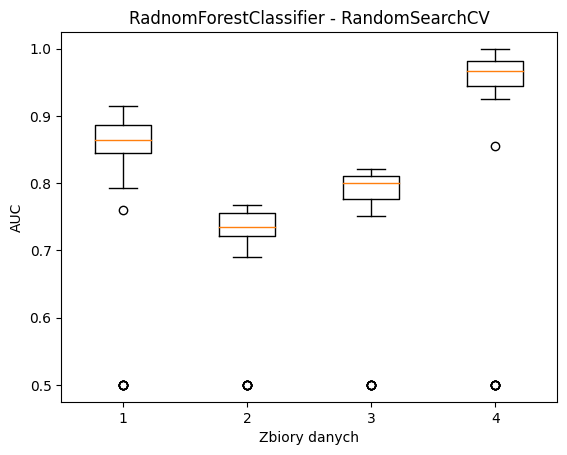

In [ ]:
plt.boxplot([results_rs["a_score"],results_rs["b_score"],results_rs["d_score"],results_rs["ba_score"]])
plt.title("RadnomForestClassifier - RandomSearchCV")
plt.xlabel("Zbiory danych")
plt.ylabel("AUC")
plt.show()

In [ ]:
results_rs.head()

,a_params,a_score,b_params,b_score,ba_params,ba_score,d_params,d_score
0,"{'bootstrap': False, 'max_features': 0.8092718...",0.832262,"{'bootstrap': False, 'max_features': 0.8092718...",0.722173,"{'bootstrap': False, 'max_features': 0.8092718...",0.931051,"{'bootstrap': False, 'max_features': 0.8092718...",0.776265
1,"{'bootstrap': True, 'max_features': 0.96159898...",0.500000,"{'bootstrap': True, 'max_features': 0.96159898...",0.500000,"{'bootstrap': True, 'max_features': 0.96159898...",0.500000,"{'bootstrap': True, 'max_features': 0.96159898...",0.500000
2,"{'bootstrap': True, 'max_features': 0.85618779...",0.847958,"{'bootstrap': True, 'max_features': 0.85618779...",0.765206,"{'bootstrap': True, 'max_features': 0.85618779...",0.966469,"{'bootstrap': True, 'max_features': 0.85618779...",0.805873
3,"{'bootstrap': False, 'max_features': 0.1846807...",0.884745,"{'bootstrap': False, 'max_features': 0.1846807...",0.727674,"{'bootstrap': False, 'max_features': 0.1846807...",0.980227,"{'bootstrap': False, 'max_features': 0.1846807...",0.800520
4,"{'bootstrap': True, 'max_features': 0.78150984...",0.847898,"{'bootstrap': True, 'max_features': 0.78150984...",0.763739,"{'bootstrap': True, 'max_features': 0.78150984...",0.963431,"{'bootstrap': True, 'max_features': 0.78150984...",0.802229


In [ ]:
ox = range(1,51,1)

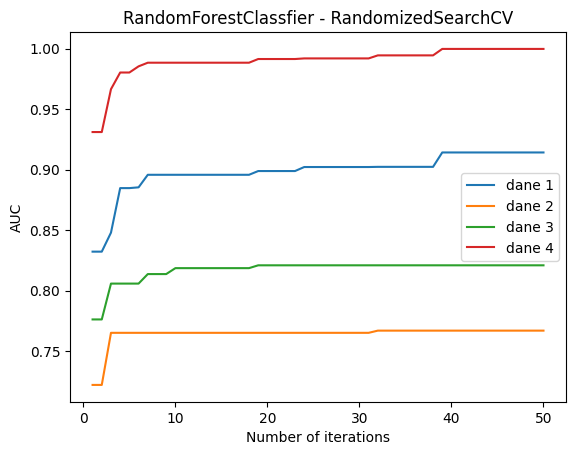

In [ ]:
plt.plot(ox, np.maximum.accumulate(results_rs['a_score']), label='dane 1')
plt.plot(ox, np.maximum.accumulate(results_rs['b_score']), label='dane 2')
plt.plot(ox, np.maximum.accumulate(results_rs['d_score']), label='dane 3')
plt.plot(ox, np.maximum.accumulate(results_rs['ba_score']), label='dane 4')

plt.legend()
plt.title("RandomForestClassfier - RandomizedSearchCV")
plt.xlabel("Number of iterations")
plt.ylabel("AUC")
plt.show()

In [ ]:
results_bs1 = pd.read_csv('results_bs1.csv')
results_bs2 = pd.read_csv('results_bs2.csv')
results_bs3 = pd.read_csv('results_bs3.csv')
results_bs4 = pd.read_csv('results_bs4.csv')

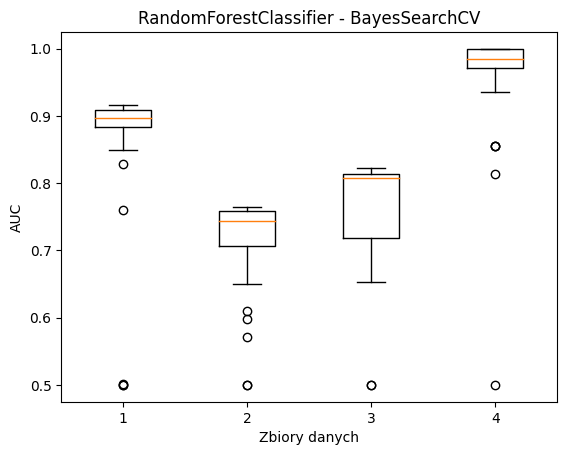

In [9]:
plt.boxplot([results_bs1["score"],results_bs2["score"],results_bs4["score"],results_bs3["score"]])
plt.title("RandomForestClassifier - BayesSearchCV")
plt.xlabel("Zbiory danych")
plt.ylabel("AUC")
plt.show()

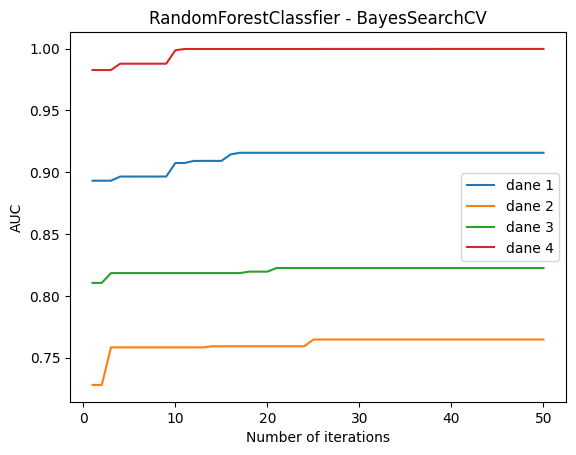

In [ ]:
plt.plot(ox, np.maximum.accumulate(results_bs1['score']), label='dane 1')
plt.plot(ox, np.maximum.accumulate(results_bs2['score']), label='dane 2')
plt.plot(ox, np.maximum.accumulate(results_bs4['score']), label='dane 3')
plt.plot(ox, np.maximum.accumulate(results_bs3['score']), label='dane 4')

plt.legend()
plt.title("RandomForestClassfier - BayesSearchCV")
plt.xlabel("Number of iterations")
plt.ylabel("AUC")
plt.show()

## Miary jakości

In [ ]:
results_rs["mean"] = results_rs.iloc[:,[1,2,3,4]].mean(axis=1)

<ipython-input-21-cee2f70b3bf4>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_rs["mean"] = results_rs.iloc[:,[1,2,3,4]].mean(axis=1)


In [ ]:
results_rs = results_rs.drop(columns=['b_params', 'ba_params', 'd_params'])
results_rs = results_rs.rename(columns={'a_params': 'params'})

In [ ]:
results_rs.head()

,params,a_score,b_score,ba_score,d_score
0,"{'bootstrap': False, 'max_features': 0.8092718...",0.832262,0.722173,0.931051,0.776265
1,"{'bootstrap': True, 'max_features': 0.96159898...",0.500000,0.500000,0.500000,0.500000
2,"{'bootstrap': True, 'max_features': 0.85618779...",0.847958,0.765206,0.966469,0.805873
3,"{'bootstrap': False, 'max_features': 0.1846807...",0.884745,0.727674,0.980227,0.800520
4,"{'bootstrap': True, 'max_features': 0.78150984...",0.847898,0.763739,0.963431,0.802229


In [ ]:
print(results_rs.loc[results_rs["mean"] == max(results_rs["mean"]),["params", "mean"]].values)

[["{'bootstrap': True, 'max_features': 0.9336580482441975, 'min_samples_split': 0.07996941969626091, 'n_estimators': 706}"
  0.8346596936921011]]


dla poszczególnych

In [ ]:
print(results_rs.loc[results_rs["a_score"]==np.max(results_rs["a_score"])]["params"].values)
print(np.max(results_rs["a_score"]))

["{'bootstrap': True, 'max_features': 0.7425674873082762, 'min_samples_split': 0.012100500892840307, 'n_estimators': 1894}"]
0.91418742855337


In [ ]:
print(results_rs.loc[results_rs["b_score"]==np.max(results_rs["b_score"])]["params"].values)
print(np.max(results_rs["b_score"]))

["{'bootstrap': True, 'max_features': 0.9336580482441975, 'min_samples_split': 0.07996941969626091, 'n_estimators': 706}"]
0.7670174833218311


In [ ]:
print(results_rs.loc[results_rs["d_score"]==np.max(results_rs["d_score"])]["params"].values)
print(np.max(results_rs["d_score"]))

["{'bootstrap': False, 'max_features': 0.4112964984806886, 'min_samples_split': 0.24121231494033568, 'n_estimators': 1377}"]
0.8209725469286193


In [ ]:
print(results_rs.loc[results_rs["ba_score"]==np.max(results_rs["ba_score"])]["params"].values)
print(np.max(results_rs["ba_score"]))

["{'bootstrap': True, 'max_features': 0.7425674873082762, 'min_samples_split': 0.012100500892840307, 'n_estimators': 1894}"]
0.9997130333899265


In [ ]:
print(results_bs1.loc[results_bs1["score"] == max(results_bs1["score"])].values)

[["OrderedDict([('bootstrap', True), ('max_features', 0.47004119610334344), ('min_samples_split', 0.01), ('n_estimators', 2000)])"
  0.9157651943341056]]


In [ ]:
print(results_bs2.loc[results_bs2["score"] == max(results_bs2["score"])].values)

[["OrderedDict([('bootstrap', True), ('max_features', 0.823453460163615), ('min_samples_split', 0.45757493869565197), ('n_estimators', 2000)])"
  0.7646523464458247]]


In [ ]:
print(results_bs4.loc[results_bs4["score"] == max(results_bs4["score"])].values)

[["OrderedDict([('bootstrap', True), ('max_features', 0.25835962595203377), ('min_samples_split', 0.040784148978595613), ('n_estimators', 1046)])"
  0.8225319579453947]]


In [ ]:
print(results_bs3.loc[results_bs3["score"] == max(results_bs3["score"])].values)

[["OrderedDict([('bootstrap', False), ('max_features', 0.11727828936695116), ('min_samples_split', 0.01), ('n_estimators', 694)])"
  0.9997972976796832]]


# Zapis danych

In [ ]:
# ## Zapis danych

from google.colab import files
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# results_bs4.to_csv("/drive/My Drive/gbc/results_bs4.csv",index=False)

# results_bs1.to_csv("/drive/My Drive/gbc/results_bs1.csv",index=False)

# results_bs2.to_csv("/drive/My Drive/gbc/results_bs2.csv",index=False)

# results_bs3.to_csv("/drive/My Drive/gbc/results_bs3.csv",index=False)

results_rs.to_csv("/drive/My Drive/rf/results_rs.csv",index=False)
